## ACURACY METRICS FOR Screen2SOM


In [1]:
from tkinter import TOP


DATA_PREFIX = "../Datasets/Dataset_640x360"
ELEMENTS_MODEL = "../Models/trained/Yolov8n-seg - Elements/best.pt"
TEXT_MODEL = "../Models/trained/Yolov8s - Text/best.pt"
CONTAINER_MODEL = "../Models/trained/CustomSAM - Container/best.pt"
APPLEVEL_MODEL = "../Models/trained/Yolov8s-seg - AppLevel/best.pt"
TOP_MODEL = "../Models/trained/Yolov8s-seg - Top/best.pt"

In [2]:
import copy
import json
import pprint

import matplotlib.pyplot as plt
import numpy as np
import torch
from hierarchy_constructor import labels_to_soms
from mapping import get_all_mapping_data, show_mappings
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from sklearn.metrics import ConfusionMatrixDisplay
from ultralytics import YOLO
from utils import *

In [3]:
pp = pprint.PrettyPrinter(indent=4).pprint

### STEP 1: GET SOMS

#### DATASET

In [4]:
dataset_labels = load_dataset(DATA_PREFIX)
dataset_soms = labels_to_soms(copy.deepcopy(dataset_labels))

100%|██████████| 100/100 [01:12<00:00,  1.38it/s]


In [ ]:
if not os.path.exists("soms"):
    os.makedirs("soms")
for file, som in dataset_soms.items():
    json.dump(som, open(f"soms/som_{file}.json", "w"))

#### PREDICTIONS

In [5]:
images = dict()
for file in os.listdir(DATA_PREFIX):
    if file.endswith(".png"):
        images[file] = f"{DATA_PREFIX}/{file}"

In [6]:
# We do it one by one to not oversaturate memory
detection_model = AutoDetectionModel.from_pretrained(
    model_type="yolov8",
    model_path=ELEMENTS_MODEL,
    confidence_threshold=0.4,
)
detections = dict()
for img_name, img_path in images.items():
    img = cv2.imread(img_path)
    result = get_sliced_prediction(
        img,
        detection_model,
        slice_height=240,
        slice_width=240,
        overlap_height_ratio=0.3,
        overlap_width_ratio=0.3,
        perform_standard_pred=True,
    )
    anns = result.to_coco_annotations()
    shapes = coco_to_labelme(anns, type="bbox", id_start=0)
    # shapes = coco_to_labelme(anns, type="seg")
    detections[img_name] = dict()
    detections[img_name]["shapes"] = shapes
    detections[img_name]["imageWidth"] = img.shape[1]
    detections[img_name]["imageHeight"] = img.shape[0]

# Unload model from memory
del detection_model
torch.cuda.empty_cache()

Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing

In [7]:
detection_model = AutoDetectionModel.from_pretrained(
    model_type="yolov8",
    model_path=TEXT_MODEL,
    confidence_threshold=0.4,
)
for img_name, img_path in images.items():
    img = cv2.imread(img_path)
    result = get_sliced_prediction(
        img,
        detection_model,
        slice_height=240,
        slice_width=240,
        overlap_height_ratio=0.3,
        overlap_width_ratio=0.3,
        perform_standard_pred=True,
    )
    anns = result.to_coco_annotations()
    shapes = coco_to_labelme(
        anns, type="bbox", id_start=len(detections[img_name]["shapes"])
    )
    # shapes = coco_to_labelme(anns, type="seg")
    detections[img_name]["shapes"].extend(shapes)

# Unload model from memory
del detection_model
torch.cuda.empty_cache()

Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing prediction on 8 number of slices.
Performing

In [8]:
model = YOLO(CONTAINER_MODEL)
for img_name, img_path in images.items():
    img = cv2.imread(img_path)
    result = json.loads(model(img, conf=0.4)[0].tojson())
    shapes = json_inference_to_labelme(
        result, type="bbox", id_start=len(detections[img_name]["shapes"])
    )
    detections[img_name]["shapes"].extend(shapes)

# Unload model from memory
del model
torch.cuda.empty_cache()


0: 384x640 (no detections), 20.7ms
Speed: 0.0ms preprocess, 20.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Sidebar, 2 Containers, 1 Image, 8.3ms
Speed: 7.0ms preprocess, 8.3ms inference, 12.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Container, 1 Image, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 TabActive, 2 TabInactives, 2 Navbars, 2 Containers, 2 Images, 1 BrowserURLInput, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 TabActive, 1 Navbar, 2 Containers, 2 Images, 1 BrowserURLInput, 17.8ms
Speed: 0.0ms preprocess, 17.8ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 TabActive, 2 TabInactives, 2 Navbars, 4 Containers, 1 BrowserURLInput, 15.6ms
Speed: 0.0ms preprocess, 15.6ms inference, 15.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x6

In [9]:
model = YOLO(APPLEVEL_MODEL)
for img_name, img_path in images.items():
    img = cv2.imread(img_path)
    result = json.loads(model(img, conf=0.4)[0].tojson())
    shapes = json_inference_to_labelme(
        result, type="seg", id_start=len(detections[img_name]["shapes"])
    )
    # shapes = json_inference_to_labelme(result, type="seg")
    detections[img_name]["shapes"].extend(shapes)

# Unload model from memory
del model
torch.cuda.empty_cache()


0: 384x640 (no detections), 30.7ms
Speed: 0.0ms preprocess, 30.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 36.3ms
Speed: 0.0ms preprocess, 36.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Headers, 32.5ms
Speed: 0.0ms preprocess, 32.5ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Header, 1 BrowserToolbar, 31.3ms
Speed: 0.0ms preprocess, 31.3ms inference, 13.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Headers, 3 BrowserToolbars, 21.2ms
Speed: 6.8ms preprocess, 21.2ms inference, 15.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 31.3ms
Speed: 0.0ms preprocess, 31.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Header, 2 BrowserToolbars, 37.4ms
Speed: 0.0ms preprocess, 37.4ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 31.3ms


In [10]:
model = YOLO(TOP_MODEL)
for img_name, img_path in images.items():
    img = cv2.imread(img_path)
    result = json.loads(model(img, conf=0.4)[0].tojson())
    shapes = json_inference_to_labelme(
        result, type="seg", id_start=len(detections[img_name]["shapes"])
    )
    # shapes = json_inference_to_labelme(result, type="seg")
    detections[img_name]["shapes"].extend(shapes)

# Unload model from memory
del model
torch.cuda.empty_cache()


0: 384x640 1 Application, 34.3ms
Speed: 0.0ms preprocess, 34.3ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Applications, 1 Taskbar, 31.3ms
Speed: 15.6ms preprocess, 31.3ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Application, 15.7ms
Speed: 6.5ms preprocess, 15.7ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Application, 4 Taskbars, 31.2ms
Speed: 15.6ms preprocess, 31.2ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 Applications, 2 Taskbars, 15.7ms
Speed: 6.5ms preprocess, 15.7ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Application, 3 Taskbars, 33.4ms
Speed: 0.0ms preprocess, 33.4ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Application, 15.7ms
Speed: 3.0ms preprocess, 15.7ms inference, 15.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 Application, 3

Finally we convert the detections to a dict of soms, just like the dataset

In [11]:
os.remove("detections.json")
json.dump(detections, open("detections.json", "w"))

In [6]:
detections = json.load(open("detections.json", "r"))

In [6]:
predicted_soms = labels_to_soms(copy.deepcopy(detections))

100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


In [ ]:
if not os.path.exists("soms"):
    os.makedirs("soms")
for file, som in tqdm(predicted_soms.items()):
    os.remove(f"soms/som_{file}_detected.json")
    json.dump(som, open(f"soms/som_{file}_detected.json", "w"))

100%|██████████| 100/100 [03:28<00:00,  2.08s/it]


In [10]:
mappings = get_all_mapping_data(detections, dataset_labels)

100%|██████████| 100/100 [15:24<00:00,  9.24s/it]


```
{
    img_name: {
        similarity_matrix,
        mapping_matrix,
        duplicates,
        orphan_detections,
        orphan_labels
    }
}
```

### Class related metrics

- Detection %
- Confusion matrix


In [11]:
labels = set()
for img_name, img in tqdm(dataset_labels.items()):
    for shape in img["shapes"]:
        labels.add(shape["label"])
labels = list(labels)

100%|██████████| 100/100 [00:00<00:00, 6669.38it/s]


In [12]:
label_count = {label: 0 for label in labels}
label_precision = {label: 0 for label in labels}
label_recall = {label: 0 for label in labels}
num_det_shapes = {label: 0 for label in labels}

# y_pred and y_true for confusion matrix
y_pred = []
y_true = []
for img_name in dataset_labels.keys():
    shapes = dataset_labels[img_name]["shapes"]
    mapping_matrix = mappings[img_name]["mapping_matrix"]

    det_shapes = detections[img_name]["shapes"]
    for shape in det_shapes:
        num_det_shapes[shape["label"]] += 1

    for shape in shapes:
        detected = np.sum(mapping_matrix[:, shape["id"]]) > 0
        label_count[shape["label"]] += 1

        if detected:
            detected_shape_id = np.argmax(mapping_matrix[:, shape["id"]])
            detected_shape = list(
                filter(
                    lambda x: x["id"] == detected_shape_id,
                    detections[img_name]["shapes"],
                )
            )[0]

            y_pred.append(detected_shape["label"])
            y_true.append(shape["label"])

            if shape["label"] == detected_shape["label"]:
                label_precision[shape["label"]] += 1
                label_recall[shape["label"]] += 1


label_precision = {
    label: label_precision[label] / num_det_shapes[label]
    if num_det_shapes[label] > 0
    else 0
    for label in label_precision
}

label_recall = {
    label: label_recall[label] / label_count[label] for label in label_recall
}

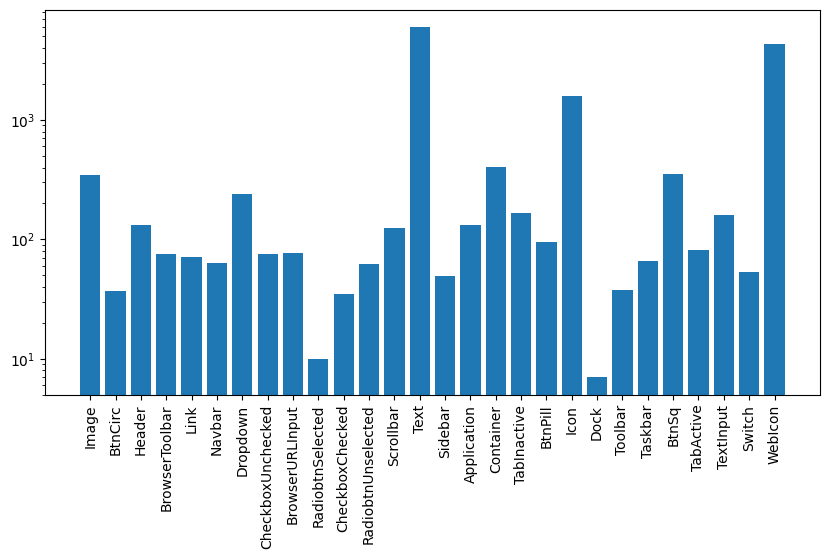

In [13]:
# Show number of shapes per label with y axis in log scale
plt.figure(figsize=(10, 5))
plt.bar(label_count.keys(), label_count.values())
plt.yscale("log")
plt.xticks(rotation=90)
plt.show()

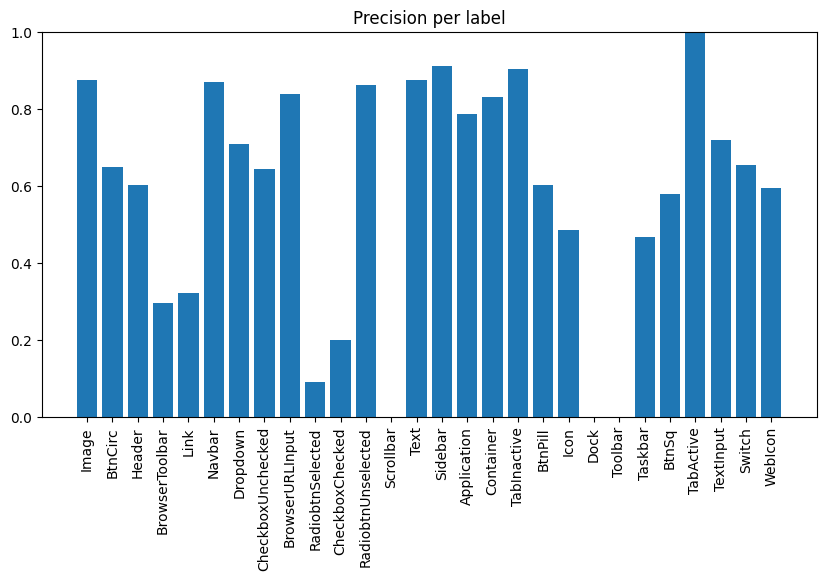

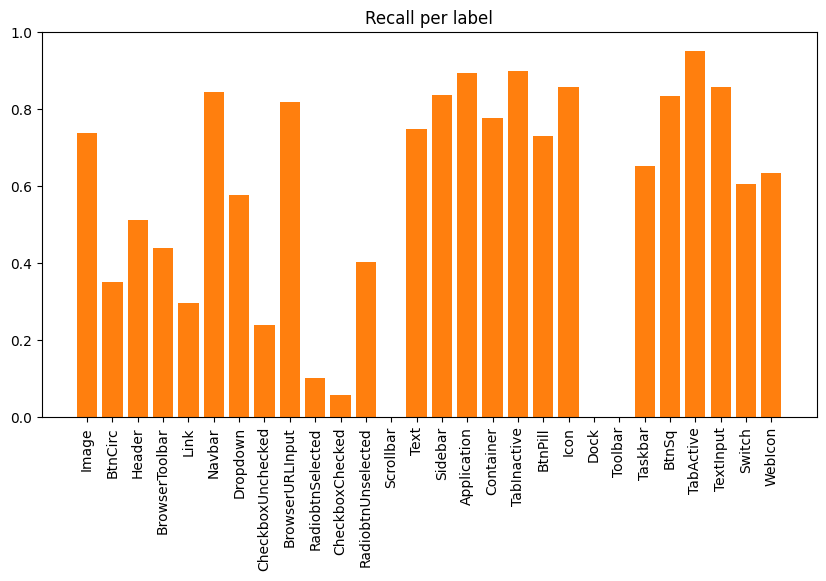

In [57]:
# Show precision and recall per label in different plots
plt.figure(figsize=(10, 5))
plt.bar(label_precision.keys(), label_precision.values())
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.title("Precision per label")
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(label_recall.keys(), label_recall.values())
plt.bar(label_recall.keys(), label_recall.values(), color="#ff7f0e")
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.title("Recall per label")
plt.show()

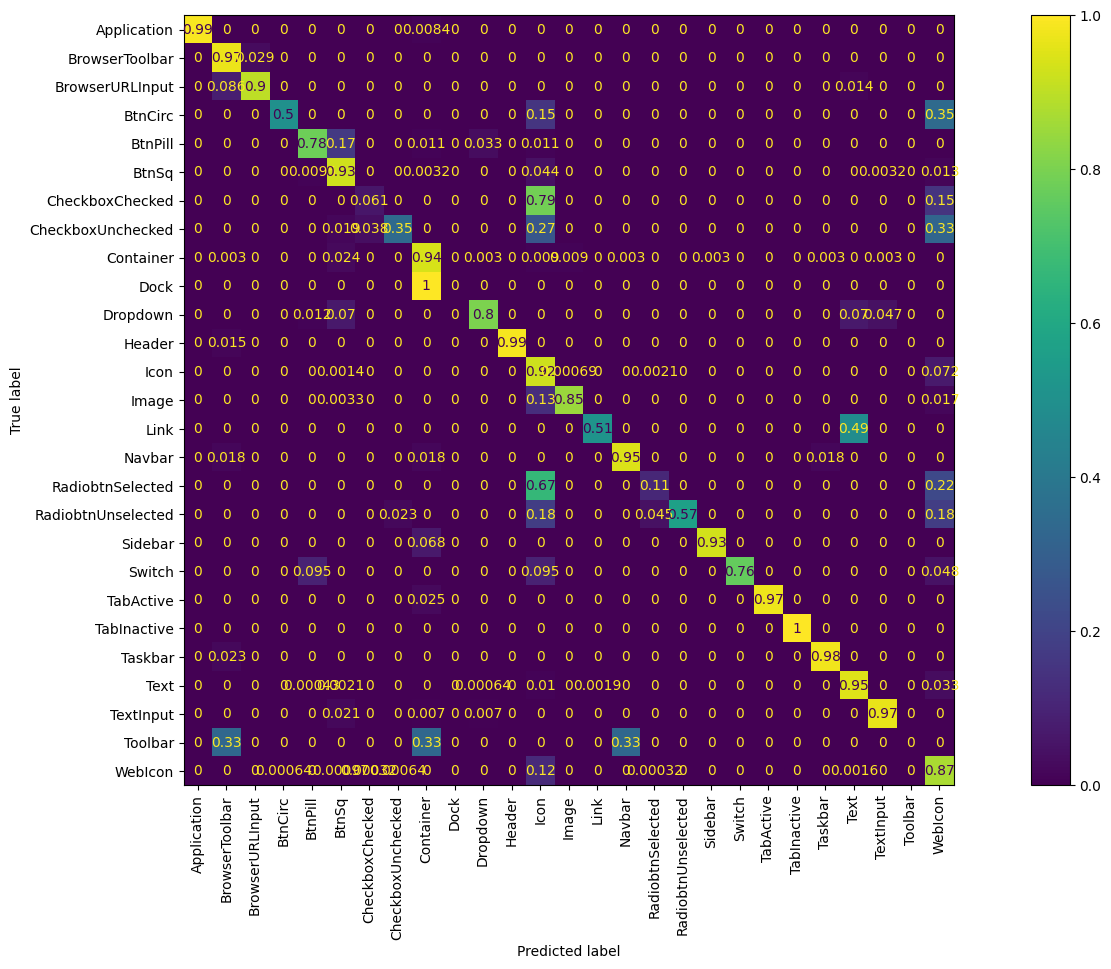

In [15]:
# ConfusionMatrixDisplay.from_predictions(
#     y_true, y_pred, normalize="true", xticks_rotation=90,
# )
# Increase the size of the commented plot
plt.rcParams["figure.figsize"] = [20, 10]
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    normalize="true",
    xticks_rotation=90,
)

### Segmentation related metrics

- IoU

These metrics are to be calculated both in a global and in a label/class basis


In [16]:
iou_acc = dict()

for img_name in dataset_labels.keys():
    iou_acc[img_name] = dict()
    mappings_per_label = dict()
    for label in labels:
        iou_acc[img_name][label] = 0.0
        mappings_per_label[label] = 0

    # Get the mapped pairs from the mapping matrix
    mapping_matrix = mappings[img_name]["mapping_matrix"]
    mapped_pairs = np.argwhere(mapping_matrix > 0)

    for pair in mapped_pairs:
        detected_shape = list(
            filter(lambda shape: shape["id"] == pair[0], detections[img_name]["shapes"])
        )[0]

        dataset_shape = list(
            filter(
                lambda shape: shape["id"] == pair[1], dataset_labels[img_name]["shapes"]
            )
        )[0]

        if detected_shape["label"] == dataset_shape["label"]:
            label = detected_shape["label"]
            det_shape_polygon = Polygon(detected_shape["points"])
            dataset_shape_polygon = Polygon(dataset_shape["points"])
            mappings_per_label[label] += 1

            iou = (
                det_shape_polygon.intersection(dataset_shape_polygon).area
                / det_shape_polygon.union(dataset_shape_polygon).area
            )

            if iou_acc[img_name][label] == 0.0:
                iou_acc[img_name][label] = iou
            else:
                # Formula from https://math.stackexchange.com/questions/22348/how-to-add-and-subtract-values-from-an-average
                iou_acc[img_name][label] = (
                    iou_acc[img_name][label]
                    + (iou - iou_acc[img_name][label]) / mappings_per_label[label]
                )

# Average IOU accuracy
iou_acc_avg = dict()
for label in labels:
    # We map the iuo accuracy dict to a list of values corresponding to the label, the filter by removing the 0 values, then we averagae
    iou_acc_avg[label] = np.average(
        list(filter(lambda x: x > 0, list(map(lambda x: x[label], iou_acc.values()))))
    )

d:\Code\Screen2SOM-Training\.venv\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
d:\Code\Screen2SOM-Training\.venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


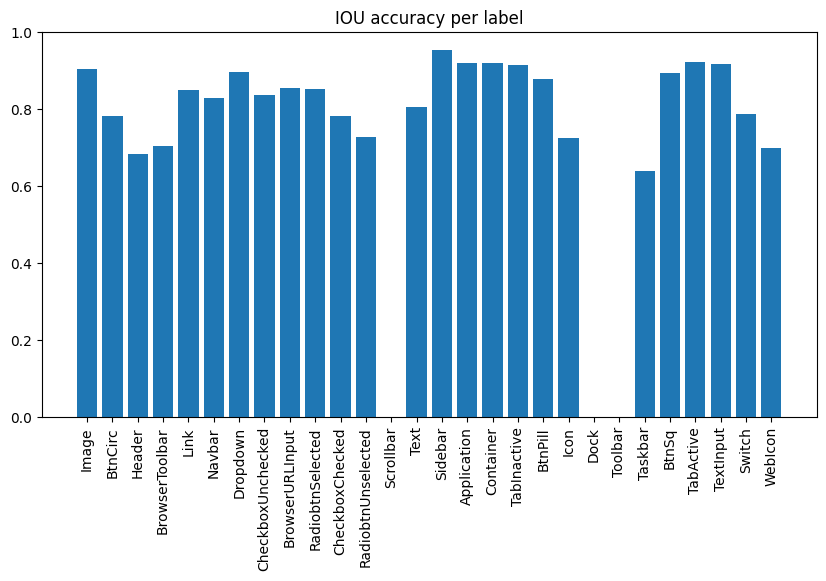

In [56]:
# Plot IOU accuracy per label
plt.figure(figsize=(10, 5))
plt.bar(iou_acc_avg.keys(), iou_acc_avg.values())
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.title("IOU accuracy per label")
plt.show()

### SOM related metrics (Métrica más importante)

- Pertenencia al SOM de cada elemento
  - Número de hijos detectados correctamente (si aplica)
  - Profundidad:
    - Podemos ver tambien si no se ha detectado
    - En el tree ¿(por cada nivel de profundidad violado aumenta el error)?
    - Esta accuracy depende de la diferencia entre la profundidad predicha y la actual pero solo afecta a los niveles
      consecuentes, ya que entonces si no detectamos, digamos, "Aplicacion", todos los elementos de esa aplicación se
      interpretaran como erróneos aunque se detecten todos los grupos y pertenencias de UI Elements a UI Groups perfectamente
  - Nodo padre correcto (si aplica)

Para cada grupo de elementos se da una puntuacion de 0 a 1 dependiendo de su similitud al SOM que se pretende conseguir
para posteriormente hacer una average con uno de los siguientes criterios:

- Todos los grupos afectan igual
- Los grupos afectan segun la cantidad de contenido (a mas hijos directos tenga un grupo, mayor su peso)
- Los grupos afectan segun su importancia (profundidad) en el SOM -> No es lo mismo fallar en un grupo pequeño que contenga
  solo un elemento a fallar en, por ejemplo, el grupo aplicación, que hara que todo el SOM se descuadre

Estos criterios han de estudiarse un poco mas para tomar una decisión. Ya que quizas con el error de profundidad no es necesario
compensar posteriormente


In [25]:
def get_tree_items(tree):
    items = []
    for item in tree:
        if item["type"] == "leaf":
            items.append(item)
        else:
            items.append(item)
            if len(item["children"]) > 0:
                items.extend(get_tree_items(item["children"]))
            else:
                item["type"] = "leaf"
    return items

In [26]:
dataset_soms_items = dict()
detected_soms_items = dict()

for img_name in dataset_soms.keys():
    dataset_soms_items[img_name] = get_tree_items(dataset_soms[img_name]["children"])
    detected_soms_items[img_name] = get_tree_items(predicted_soms[img_name]["children"])

In [87]:
SOM_detection_metrics = {
    "depth_acc": 0.0,
    "precision": 0.0,
    "recall": 0.0,
    "missed_children": 0.0,
    "detection_acc": 0.0,
    "false_det": {"total": 0, "class": 0.0, "segment": 0.0},
}

In [88]:
from math import e
import re


depth_acc = dict()
recall = dict()
precision = dict()
missed_children = dict()
detection_acc = dict()
false_det = dict()

for img_name in dataset_soms_items.keys():
    depth_acc[img_name] = 0.0
    # Recall and precision are calculated per node and then weighted averaged by the number of children
    recall[img_name] = dict()
    precision[img_name] = dict()

    # Weights for recall and precision
    weights = []

    missed_children[img_name] = 0.0
    detection_acc[img_name] = 0.0
    false_det[img_name] = {"total": 0, "class": 0.0, "segment": 0.0}

    mapping_matrix = mappings[img_name]["mapping_matrix"]
    orphan_detections = mappings[img_name]["orphan_detection"]
    duplicates = mappings[img_name]["duplicates"]

    non_duplicate_orphans = list(
        filter(lambda x: not any(x in d for d in duplicates), orphan_detections)
    )

    dataset_items = dataset_soms_items[img_name]
    detected_items = detected_soms_items[img_name]

    for shape in dataset_items:
        mapped_node_id = np.argmax(mapping_matrix[:, shape["id"]])
        mapped_node = list(filter(lambda n: n["id"] == mapped_node_id, detected_items))[
            0
        ]

        # Calculate recall and precision in a per-node basis
        if shape["type"] == "root" or shape["type"] == "node":
            recall[img_name][shape["id"]] = 0.0
            precision[img_name][shape["id"]] = 0.0

            for child in shape["children"]:
                if np.sum(mapping_matrix[:, child["id"]]) > 0:
                    mapped_shape_id = np.argmax(mapping_matrix[:, child["id"]])
                    mapped_shape = list(
                        filter(lambda s: s["id"] == mapped_shape_id, detected_items)
                    )[0]

                    if mapped_shape in mapped_node["children"]:
                        if mapped_shape["label"] == child["label"]:
                            recall[img_name][shape["id"]] += 1
                            precision[img_name][shape["id"]] += 1
                        else:
                            false_det[img_name]["class"] += 1

                    else:
                        if mapped_shape["label"] == child["label"]:
                            missed_children[img_name] += 1

            # Normalize recall and precision and add weights
            recall[img_name][shape["id"]] /= len(shape["children"])
            if len(mapped_node["children"]) > 0:
                precision[img_name][shape["id"]] /= len(mapped_node["children"])
            else:
                precision[img_name][shape["id"]] = 0

            weights.append(len(shape["children"]))

        # Calculate the rest of metrics in the same way
        if np.sum(mapping_matrix[:, shape["id"]]) > 0:
            if mapped_node["label"] == shape["label"]:
                if mapped_node["depth"] == shape["depth"]:
                    depth_acc[img_name] += 1

                detection_acc[img_name] += 1

            else:
                false_det[img_name]["class"] += 1

    false_det[img_name]["segment"] = len(non_duplicate_orphans)
    false_det[img_name]["total"] += (
        false_det[img_name]["class"] + false_det[img_name]["segment"]
    )

    # Normalize values
    # Right now we can use detection_acc as the number of relevant retrieved instances
    depth_acc[img_name] /= len(dataset_items)
    detection_acc[img_name] /= len(dataset_items)

    false_det[img_name]["total"] /= len(detected_items)
    false_det[img_name]["class"] /= len(detected_items)
    false_det[img_name]["segment"] /= len(detected_items)

    # Weighted average for recall and precision
    recall[img_name] = np.average(list(recall[img_name].values()), weights=weights)
    precision[img_name] = np.average(
        list(precision[img_name].values()), weights=weights
    )

    missed_children[img_name] /= len(dataset_items)

In [90]:
# Calculate averaged metrics
SOM_detection_metrics["depth_acc"] = np.average(list(depth_acc.values()))
SOM_detection_metrics["precision"] = np.average(list(precision.values()))
SOM_detection_metrics["recall"] = np.average(list(recall.values()))
SOM_detection_metrics["missed_children"] = np.average(list(missed_children.values()))
SOM_detection_metrics["detection_acc"] = np.average(list(detection_acc.values()))
SOM_detection_metrics["false_det"]["total"] = np.average(
    [false_det[img_name]["total"] for img_name in false_det.keys()]
)
SOM_detection_metrics["false_det"]["class"] = np.average(
    [false_det[img_name]["class"] for img_name in false_det.keys()]
)
SOM_detection_metrics["false_det"]["segment"] = np.average(
    [false_det[img_name]["segment"] for img_name in false_det.keys()]
)

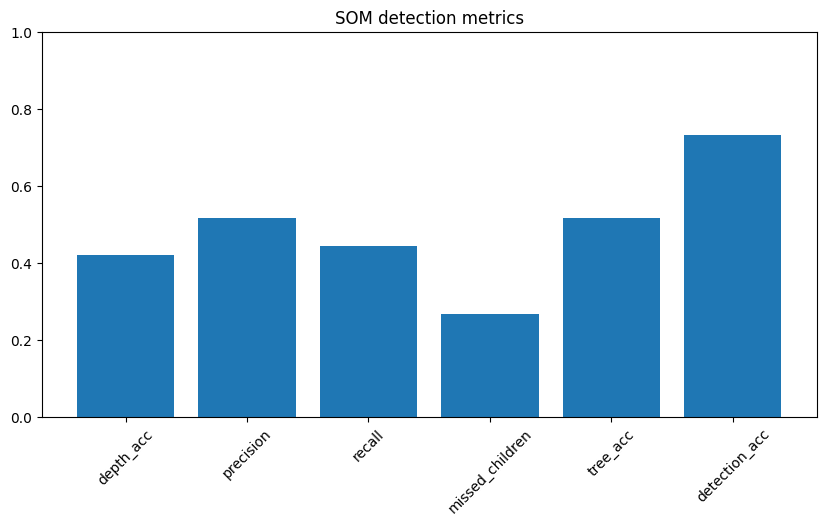

In [91]:
SOM_detection_metrics_no_false_det = copy.deepcopy(SOM_detection_metrics)
del SOM_detection_metrics_no_false_det["false_det"]
# Plot metrics with y scale 0 to 1
plt.figure(figsize=(10, 5))
plt.bar(
    SOM_detection_metrics_no_false_det.keys(),
    SOM_detection_metrics_no_false_det.values(),
)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.title("SOM detection metrics")
plt.show()

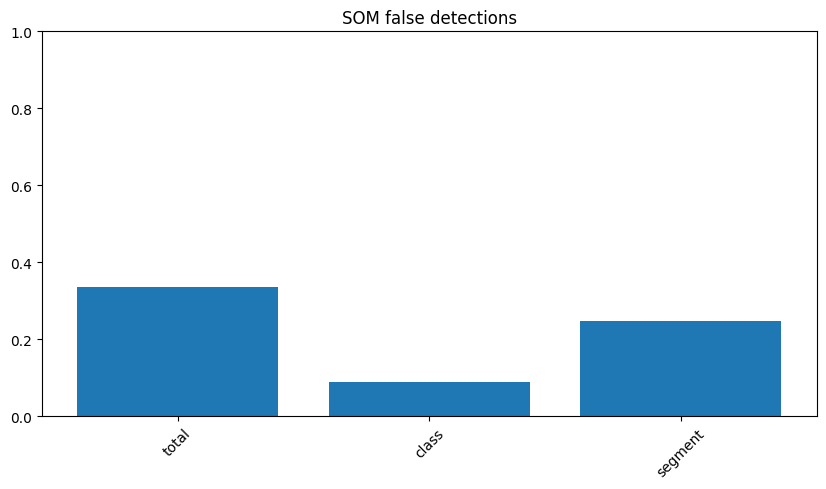

In [92]:
# False detections
plt.figure(figsize=(10, 5))
plt.bar(
    SOM_detection_metrics["false_det"].keys(),
    SOM_detection_metrics["false_det"].values(),
)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.title("SOM false detections")
plt.show()

In [ ]:
# Show mappings
for img_name, img_path in images.items():
    show_mappings(
        img_path,
        detections[img_name]["shapes"],
    )

In [21]:

def show_mappings(img_path, detected_shapes):
    tint_colors = {}
    for i in range(len(detected_shapes)):
        if detected_shapes[i]["label"] not in tint_colors:
            tint_colors[detected_shapes[i]["label"]] = (
                np.random.randint(0, 255),
                np.random.randint(0, 255),
                np.random.randint(0, 255),
            )

    img = cv2.imread(img_path)
    for i in range(len(detected_shapes)):
        # Show both polygons (labeled and detected)
        cv2.polylines(
            img,
            np.int32([detected_shapes[i]["points"]]),
            True,
            (255, 0, 0),
            2,
        )

    cv2.imshow("mappings", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()